# RNAseq analysis using DESeq2

In [1]:
library("DESeq2")
library(scales)
library(data.table)
library(pheatmap)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

Navigate to the correct directory:

In [2]:
setwd(path.expand("/mnt/storage/r0773125/jupyternotebooks/RNA-seq"))

Define the file containing the raw counts (the ones we generated last session):

In [3]:
matrixFile = path.expand("/mnt/storage/r0773125/jupyternotebooks/RNA-seq/all.gene.counts")

In [47]:
# read in count data
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))

# check count data
head(countData)

,YT1.bam,YT2.bam,YS1.bam,YS2.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,0
RP11-34P13.8,0,0,0,0
AL627309.1,18,23,10,15


Give column names for DESeq experiment. C is for 'control' and K is for 'knockdown'.

In [5]:
colnames(countData) <- c("C1", "C2", "K1", "K2")
head(countData)

,C1,C2,K1,K2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,0
RP11-34P13.8,0,0,0,0
AL627309.1,18,23,10,15


View the amount of reads per sample

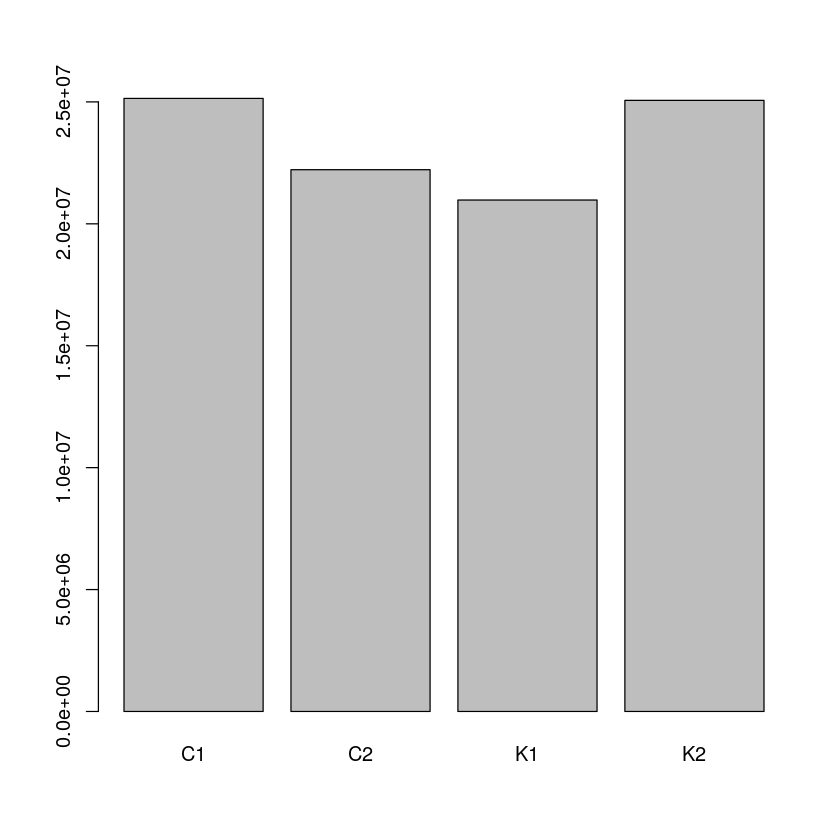

In [6]:
# amount of reads per sample
barplot(colSums(countData))

Define the experimental conditions: C is the control knockdown, YS is the UHRF1 knockdown.

In [7]:
condition <- factor(c("C", "C", "K", "K"))
print(condition)

[1] C C K K
Levels: C K


Prepare a dataframe with the names and conditions. This will be fed to DESeq2.

In [8]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
C1,C
C2,C
K1,K
K2,K


Here we create a DESeq `DESeqDataSet` object for subsequent analysis:

In [9]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

## Run the differential expression:

In [12]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Quality Control
The next step in the DESeq2 workflow is QC, which includes sample-level and gene-level steps to perform QC checks on the count data to help us ensure that the samples/replicates look good.

## Sample-level QC
A useful initial step in an RNA-seq analysis is often to assess overall similarity between samples:

- Which samples are similar to each other, which are different?
- Does this fit to the expectation from the experiment’s design?
- What are the major sources of variation in the dataset?

To explore the similarity of our samples, we will be performing sample-level QC using Principal Component Analysis (PCA) and hierarchical clustering methods. Our sample-level QC allows us to see how well our replicates cluster together, as well as, observe whether our experimental condition represents the major source of variation in the data. Performing sample-level QC can also identify any sample outliers, which may need to be explored further to determine whether they need to be removed prior to DE analysis. Naturally, some of these analyses don't make much sense when we only have two conditions, each with two replicates. But it's useful to illustrate nonetheless and I wanted to show I made the effort to go further in depth with the QC.

When using these unsupervised clustering methods, log2-transformation of the normalized counts improves the clustering for visualization. DESeq2 uses a regularized log transform (rlog) of the normalized counts for sample-level QC as it moderates the variance across the mean, improving the clustering.

### Principle Components Analysis
If two samples have similar levels of expression for the genes that contribute significantly to the variation represented by PC1, they will be plotted close together on the PC1 axis. Therefore, we would expect that biological replicates to have similar scores (since the same genes are changing) and cluster together on PC1 and/or PC2, and the samples from different treatment groups to have different score. This is easiest to understand by visualising example PCA plots.

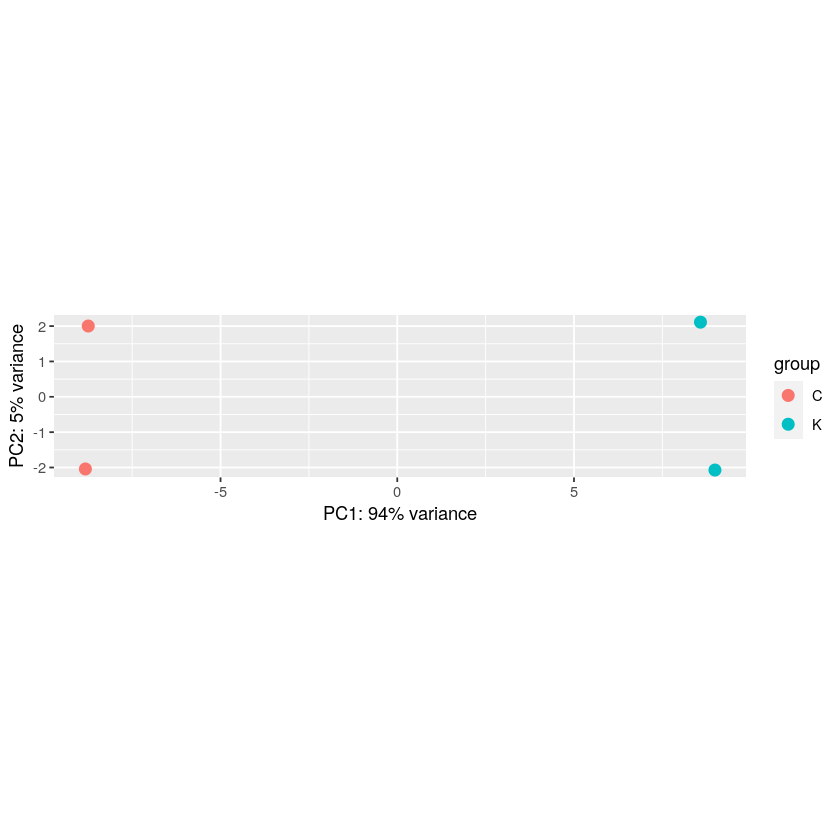

In [13]:
# Transform counts for data visualization
rld <- rlog(dds, blind=TRUE)
plotPCA(rld, intgroup="condition")

The PCA plot shows that the first principle component contains 94% of the variance, and that the conditions are well separated along this dimension. The replicates are further separated by the second principle component, although this only accounts for 2.5% of the variance.

### Hierarchical Clustering Heatmap
Similar to PCA, hierarchical clustering is another, complementary method for identifying strong patterns in a dataset and potential outliers. The heatmap displays the correlation of gene expression for all pairwise combinations of samples in the dataset. Since the majority of genes are not differentially expressed, samples generally have high correlations with each other. Samples below 0.80 may indicate sample contamination.

The hierarchical tree can indicate which samples are more similar to each other based on the normalized gene expression values. The color blocks indicate substructure in the data, and you would expect to see your replicates cluster together as a block for each sample group. Additionally, we expect to see samples clustered similar to the groupings observed in a PCA plot.

Since there is no built-in function for heatmaps in DESeq2 we will be using the `pheatmap()` function from the pheatmap package. This function requires a matrix/dataframe of numeric values as input, and so the first thing we need to is retrieve that information from the rld object:

In [14]:
rld_mat <- assay(rld)

Compute the pairwise correlation values for samples using the `cor()` function:

In [15]:
rld_cor <- cor(rld_mat)

Plot the correlation values as a heatmap:

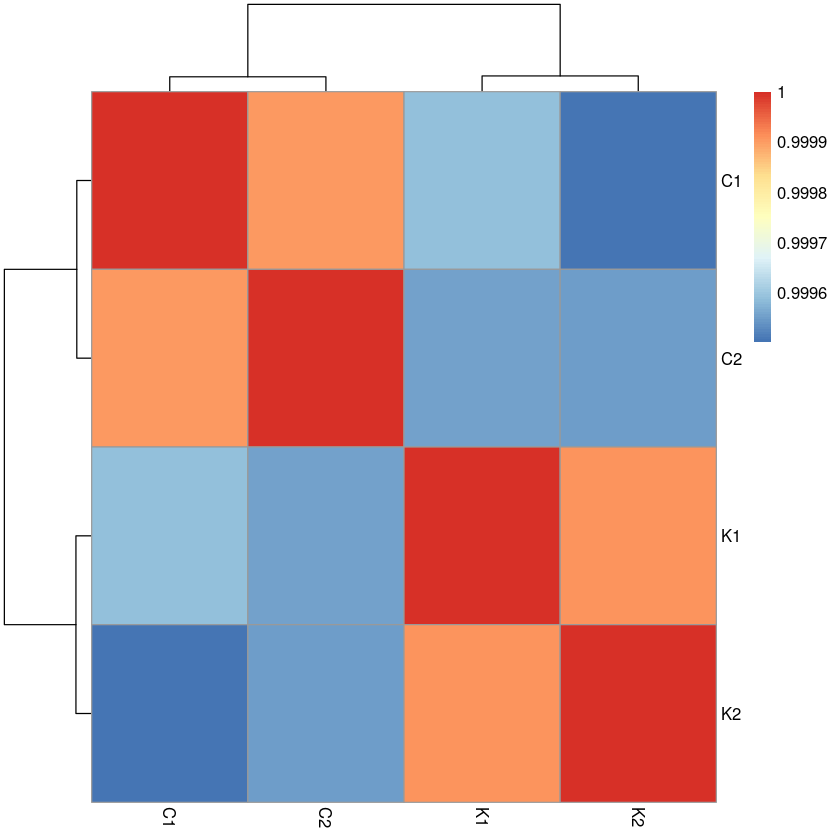

In [16]:
pheatmap(rld_cor)

The replicates cluster together as expected. 

Lastly, we can make scatter plot of sample vs sample will show us how the samples compare. It is clear that the replicates are more similar to each other than between conditions.

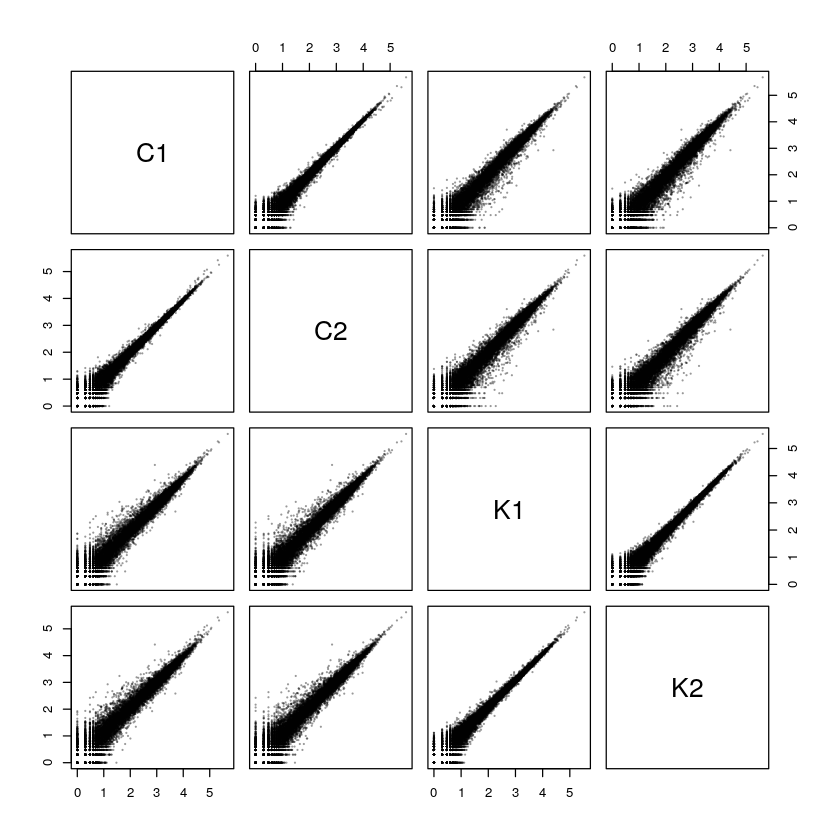

In [17]:
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

### Gene-level QC
Prior to differential expression analysis it is beneficial to omit genes that have little or no chance of being detected as differentially expressed. DESeq does this by default however so I won't get into this here.

# Differential Expression Analysis
The count data generated by RNA-seq exhibits overdispersion (variance > mean) and the statistical distribution used to model the counts needs to account for this overdispersion. DESeq2 uses a negative binomial distribution to model the RNA-seq counts.

DESeq2 will use this formula as our model for each gene, and fit the normalized count data to it. After the model is fit, coefficients are estimated for each sample group along with their standard error. The coefficents are the estimates for the log2 foldchanges for each sample group. However, these estimates do not account for the large dispersion we observe with low read counts. To avoid this, the log2 fold changes calculated by the model need to be adjusted.

## Shrunken log2 foldchanges (LFC)
To generate more accurate log2 foldchange estimates, DESeq2 allows for the shrinkage of the LFC estimates toward zero when the information for a gene is low, which could include:

 - Low counts
 - High dispersion values

As with the shrinkage of dispersion estimates, LFC shrinkage uses information from all genes to generate more accurate estimates. Specifically, the distribution of LFC estimates for all genes is used (as a prior) to shrink the LFC estimates of genes with little information or high dispersion toward more likely (lower) LFC estimates.

In [18]:
resultsNames(dds)

[1] "Intercept"        "condition_K_vs_C"

In [19]:
# results for unshrunken and shrunked LFCs
res_unshrunken <- results(dds, alpha = 0.05)
contrast <- c("condition", "K", "C")
res_shrunken <- lfcShrink(dds, contrast=contrast, res=res_unshrunken)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



## MA plot
The MA plot shows the mean of the normalized counts versus the log2 foldchanges for all genes tested. The genes that are significantly DE are colored to be easily identified. We can use the MA plot to view the effects of LFC shrinkage

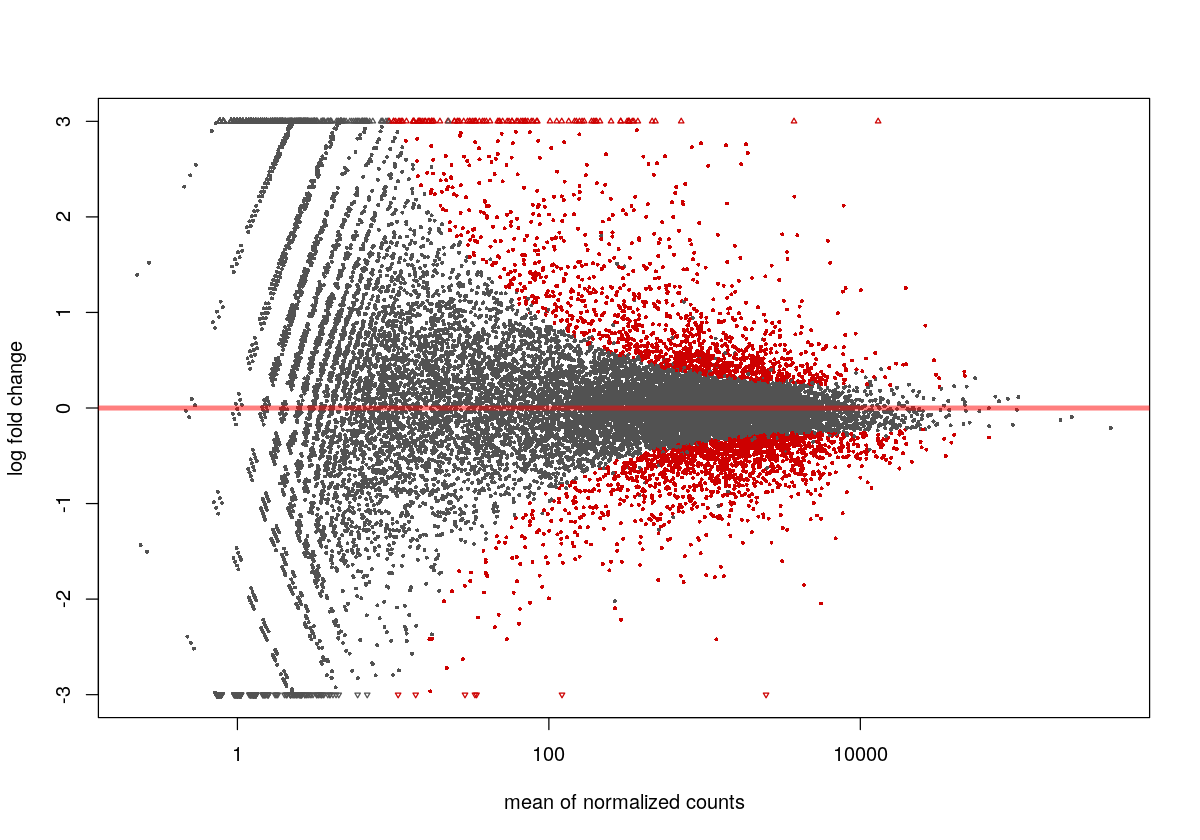

In [20]:
options(repr.plot.width=10, repr.plot.height=7)
plotMA(res_unshrunken, ylim=c(-3,3))

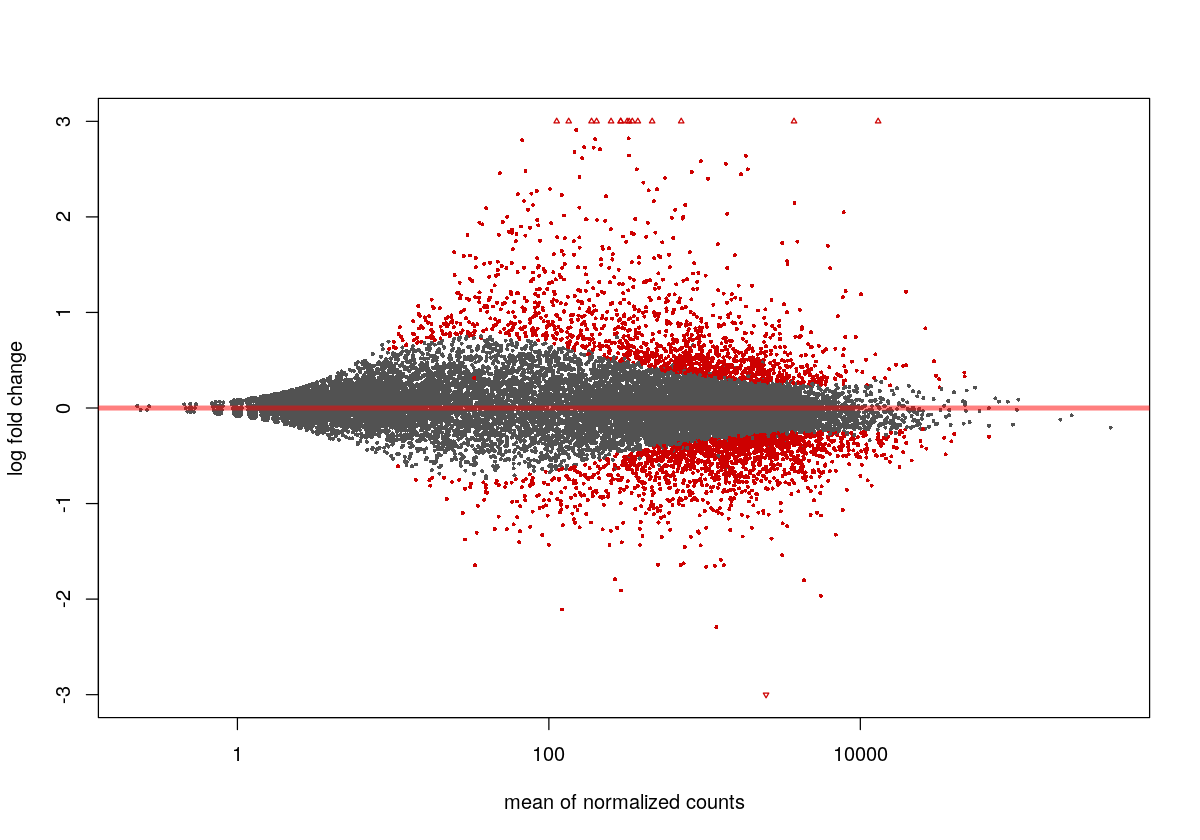

In [21]:
options(repr.plot.width=10, repr.plot.height=7)
plotMA(res_shrunken, ylim=c(-3,3))

We can clearly see the effects of LFC shrinkage here. Furthermore, it seems that there are more significantly up-regulated genes with high LFCs.

# Export and visualise the results

In [23]:
res_us <- res_unshrunken[order(res_unshrunken$padj),]
res_s <- res_shrunken[order(res_shrunken$padj),]
head(res_s)

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 6 rows and 6 columns
                baseMean    log2FoldChange             lfcSE              stat
               <numeric>         <numeric>         <numeric>         <numeric>
RCVRN   13012.0630398435  4.87355936460648 0.103428784519538  46.9621792249915
SUSD2   3750.29753383858  3.07810326145792 0.125660289221921  24.4475292093994
UHRF1   2481.16663973242 -3.16882656348784   0.1438294241912 -21.9620181819477
MYO5B   1840.62993187403  2.63764461572716 0.120201327576508  21.8863077251312
DBH-AS1 707.606037844285  4.56772020966474  0.19443279148833  21.8763353587858
SEPT4   3776.76355499303  2.14426051612718 0.100494504056249  21.3227641492457
                       pvalue                  padj
                    <numeric>             <numeric>
RCVRN                       0                     0
SUSD2   5.34629262974871e-132 3.92230758781514e-128
UHRF1   6.64799390048026e-107  3.251533816724

Checking the number of significantly differentially expressed genes for both shrunken and unshrunken data. Naturally its the same as the shrinkage only affects LFC.

In [24]:
res_us.sign <- res_us[(!is.na(res_us$padj)) & (res_us$padj < 0.05),]
res_s.sign <- res_s[(!is.na(res_s$padj)) & (res_s$padj < 0.05),]

dim(res_us.sign)
dim(res_s.sign)

[1] 3011    6

[1] 3011    6

Add genes to dataframe as the first column and save results to disk:

In [27]:
write.table(res_s, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)
write.table(res_us, "deseq.results.unshrunken.tsv", sep="\t", col.names=NA, quote=FALSE)

It is alwasy important to manually check a number of diff. expressing genes. As expected, CDK1NA goes up in the stimulated cells:

# Context specific analysis
The relevant findings of the paper (discussed in detail in the master notebook) were:

1. UHRF1 depletion impedes DNA repair by downregulating XRCC4

2. UHRF1 depletion leads to the depletion of redox-responsive genes such as GSTA4 and TXN2 in RB cells 

3. UHRF1 depletion derepresses the expression of photoreceptor-speciﬁc genes in RB cells and promotes neuron-like differentiation. 

I should first do a check using a positive control gene, a gene whose response to UHRF1 downmodulation is known and predictable. However, after reading the literature, I couldn't find an obvious positive control gene candidate that wasn't related to reactive oxygen species homeostasis (which is part of the analysis here anyways). It's not ideal to use a gene whose response we are studying as the positive control gene but I wanted to show it nonetheless. The coverage for TXN2 is given in the image below. The data ranges have the same scale. We can see that TXN2 is downregulated in the UHRF1 knowckdown samples.

![poscontrol](RNA-seq/TXN2.png)

Let's also check that UHRF1 has been properly knocked down:

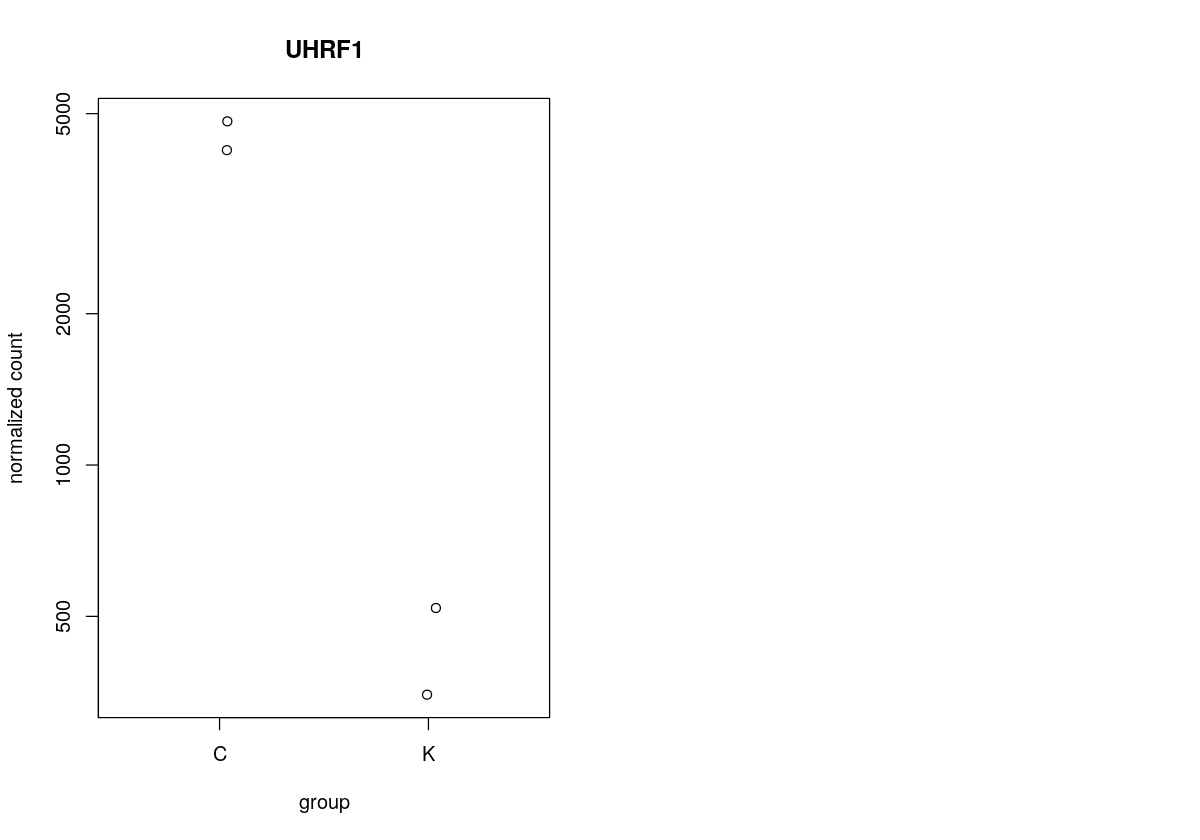

In [26]:
par(mfrow=c(1,2))
plotCounts(dds, gene="UHRF1", normalized = TRUE) 

In [48]:
res_s['UHRF1',]

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
              baseMean    log2FoldChange           lfcSE              stat
             <numeric>         <numeric>       <numeric>         <numeric>
UHRF1 2481.16663973242 -3.16882656348784 0.1438294241912 -21.9620181819477
                     pvalue                 padj
                  <numeric>            <numeric>
UHRF1 6.64799390048026e-107 3.2515338167249e-103

Now let's check the redox-responsive genes:

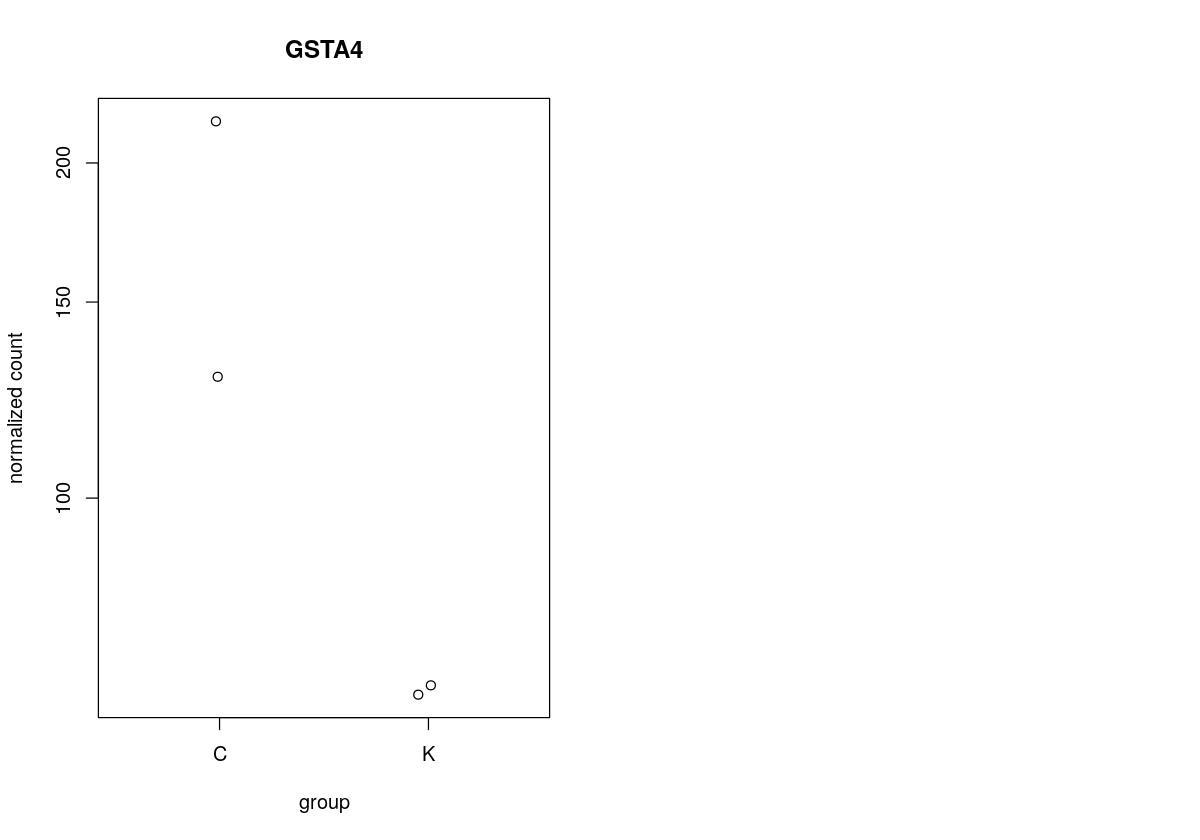

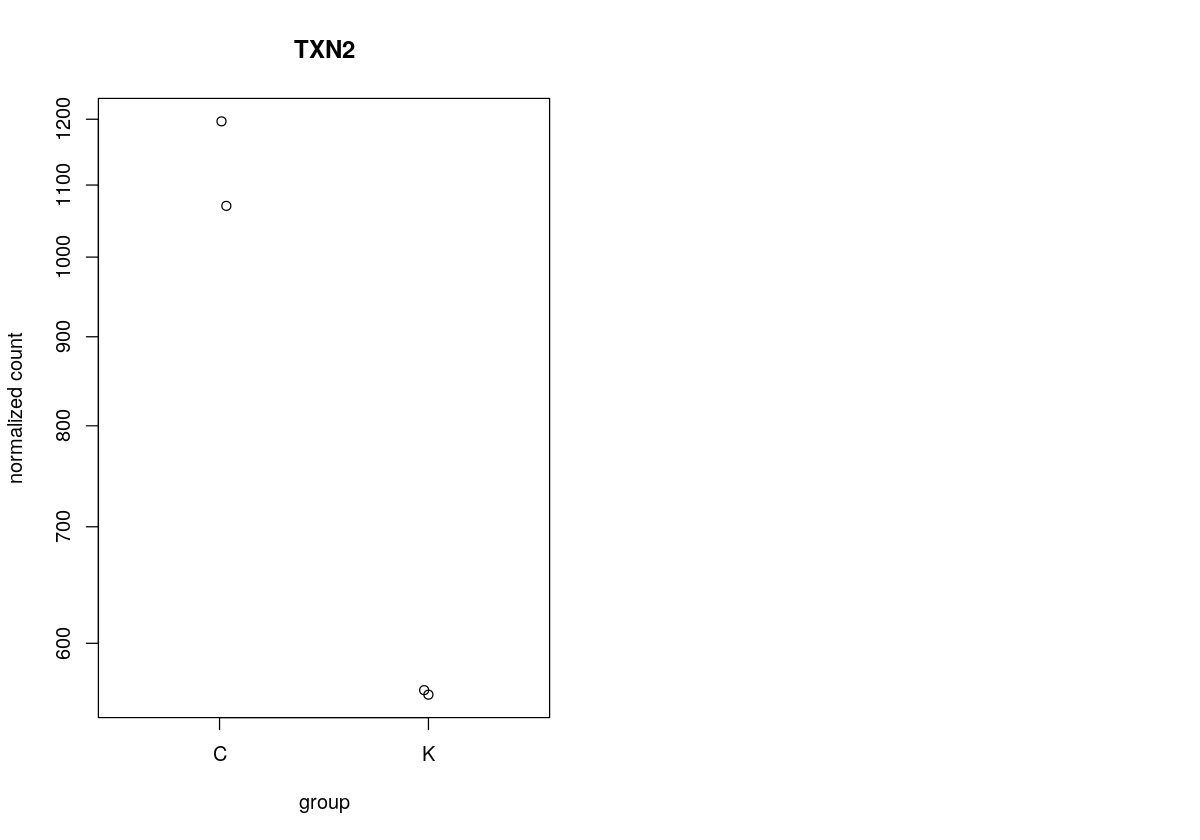

In [37]:
par(mfrow=c(1,2))
plotCounts(dds, gene="GSTA4", normalized = TRUE)

par(mfrow=c(1,2))
plotCounts(dds, gene="TXN2", normalized = TRUE) 

In [39]:
res_s['GSTA4',]

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
              baseMean    log2FoldChange             lfcSE              stat
             <numeric>         <numeric>         <numeric>         <numeric>
GSTA4 119.751023563565 -1.01059693679765 0.257397378806083 -3.91789843045808
                    pvalue                 padj
                 <numeric>            <numeric>
GSTA4 8.93243266087147e-05 0.000947690415278142

In [38]:
res_s['TXN2',]

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
             baseMean    log2FoldChange             lfcSE              stat
            <numeric>         <numeric>         <numeric>         <numeric>
TXN2 847.325409909324 -0.95542130055302 0.135230866050901 -7.06193382001729
                 pvalue                 padj
              <numeric>            <numeric>
TXN2 1.642011924526e-12 8.25011672119659e-11

Both are significantly downregulated, as expected. Why is this relevant? The paper outlines that the downregulation of GSTA4 and TXN2 upon UHRF1 depletion suggests that these cells may encounter increased oxidative stress due to the impaired reactive oxygen species (ROS) detoxiﬁcation, contributing to enhanced susceptibility to ROS-mediated apoptosis driven by HDAC inhibitors.

They also found that UHRF1 depletion impedes DNA repair in RB cells by down-regulating XRCC4, which is involved in nonhomologous end-joining repair. This leads to higher apoptotic cell death in response to DNA damages induced by the genotoxic drugs. The results below show that XRCC4 is significantly downregulated upon UHRF1 depletion.

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
              baseMean     log2FoldChange             lfcSE            stat
             <numeric>          <numeric>         <numeric>       <numeric>
XRCC4 2533.67256293571 -0.427175648445215 0.122907138855393 -3.475505975421
                    pvalue               padj
                 <numeric>          <numeric>
XRCC4 0.000509890633115623 0.0042292963593587

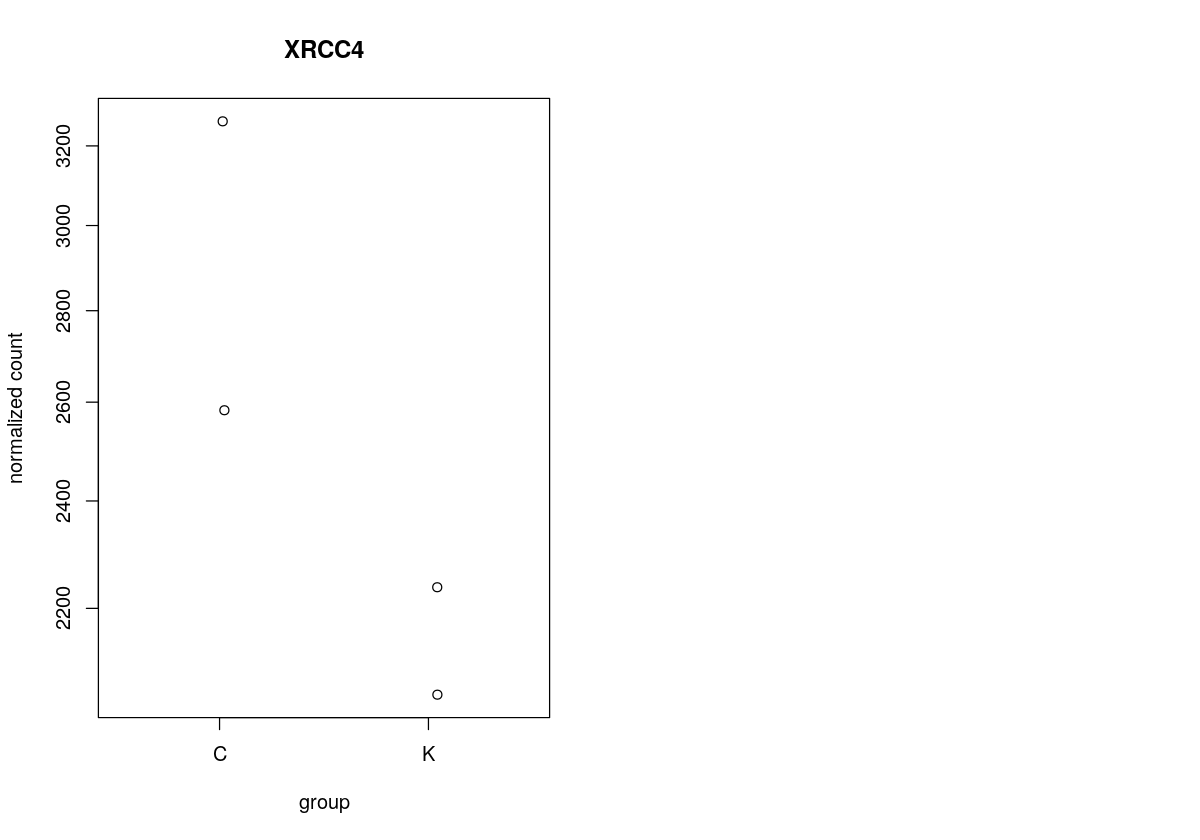

In [43]:
par(mfrow=c(1,2))
plotCounts(dds, gene="XRCC4", normalized = TRUE) 
res_s['XRCC4',]

Lastly, the paper reports that another potential mechanism for HDAC inhibitors to exert growth-inhibitory effects in cancer cells is induction of cellular differentiation through lineage-speciﬁc gene expression and cell cycle exit. They discovered that UHRF1 directly represses the expression of photoreceptor genes in Y79 cells in cooperation with HDACs and also indirectly by its downstream target. 

For example, RXGR is a critical transcription factor for photoreceptor development, and RXRG expression is induced by UHRF1 depletion. RXRG expression data for control and knockdown is given below, showing that it is significantly upregulated, but that the LFC is not large enough for it to be added to the original list of DEGs (when using the arbitrary cut-off). In the next notebook we'll see that photoreceptor development is one of the ontologies picked up in the gene ontology enrichment analysis.

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
             baseMean    log2FoldChange             lfcSE             stat
            <numeric>         <numeric>         <numeric>        <numeric>
RXRG 3014.89540815053 0.914438816087357 0.272823714073483 3.35906826447323
                   pvalue                padj
                <numeric>           <numeric>
RXRG 0.000782057460168444 0.00607471101802624

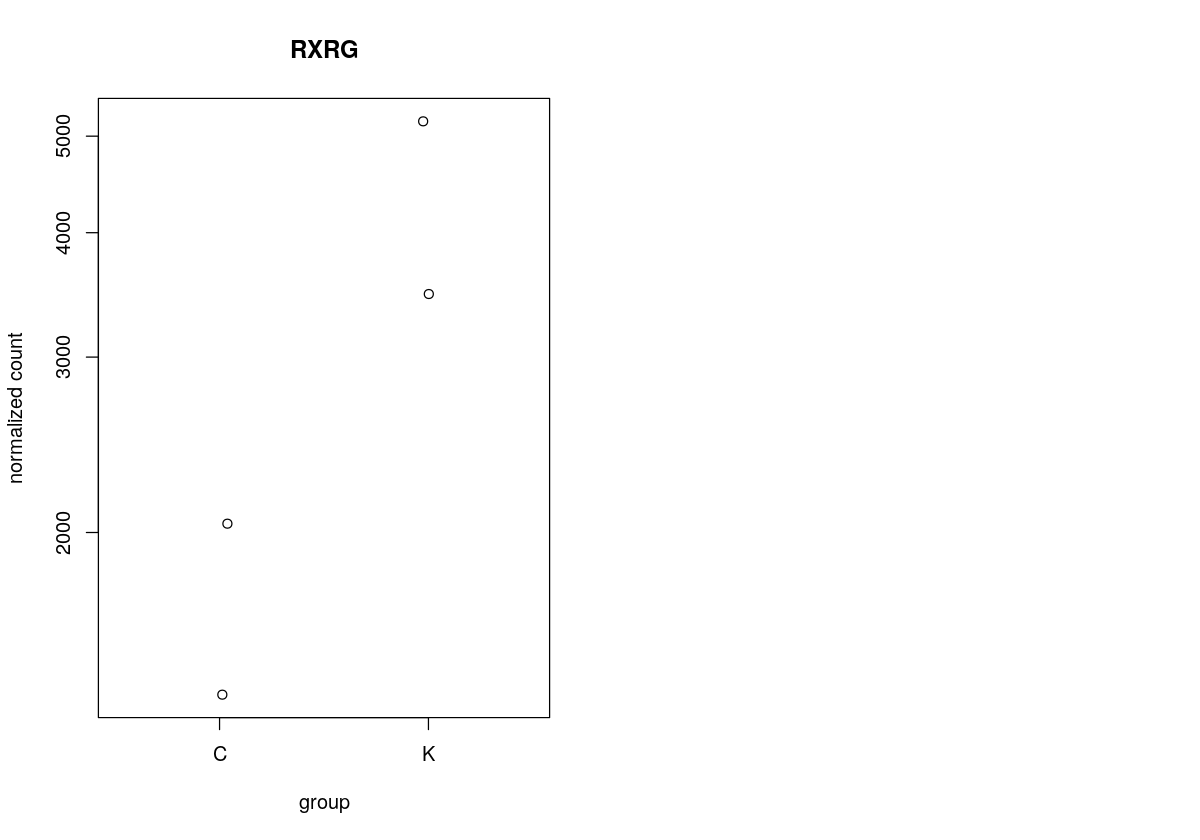

In [44]:
par(mfrow=c(1,2))
plotCounts(dds, gene="RXRG", normalized = TRUE) 
res_s['RXRG',]

A number of genes also related to phototransduction are also significantly upregulated. This includes recoverin, which acts as a calcium sensor and regulates phototransduction of cone and rod photoreceptor cells. The upregulation of genes like RCVRN is likely due to increased histone H3 acetylation at photoreceptor gene promotors. UHRF1 forms a complex with HDAC1 and binds to methylated promoters. The down-modulation of UHRF1 therfore increases acetylation at gene promotors, leading to upregulation of certain photoreceptor genes.

The gene ontology enrichment analysis performed in the next notebook reveals that many photoreceptor-speciﬁc genes are upregulated in UHRF1-depleted cells, which is consistent with previous reports that human retinoblastomas display photoreceptor-like features.

log2 fold change (MAP): condition K vs C 
Wald test p-value: condition K vs C 
DataFrame with 1 row and 6 columns
              baseMean   log2FoldChange             lfcSE             stat
             <numeric>        <numeric>         <numeric>        <numeric>
RCVRN 13012.0630398435 4.87355936460648 0.103428784519538 46.9621792249915
         pvalue      padj
      <numeric> <numeric>
RCVRN         0         0

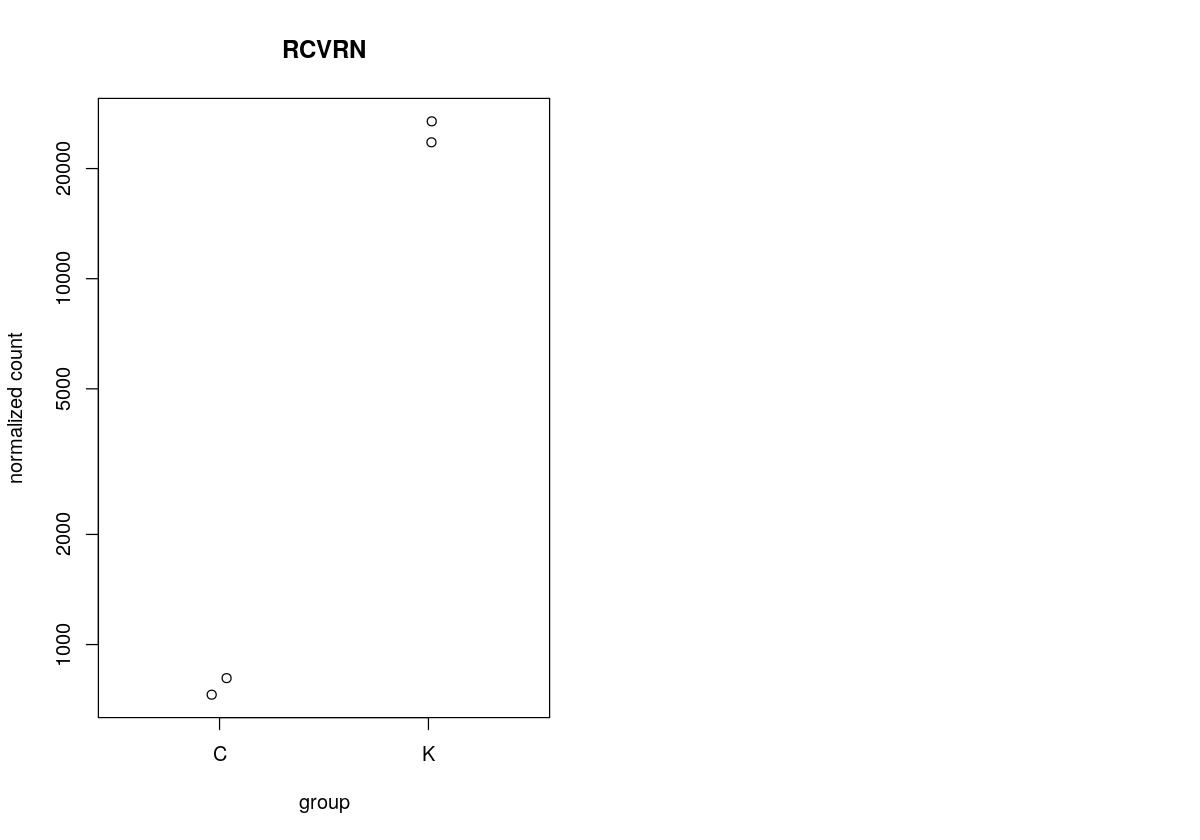

In [45]:
par(mfrow=c(1,2))
plotCounts(dds, gene="RCVRN", normalized = TRUE) 
res_s['RCVRN',]

In [34]:
res_s.sorted <- res_s[order(res_s$padj),]

In [35]:
# identify genes with the desired adjusted p-value cut-off
DGEgenes <- rownames(subset(res_s.sorted, padj < 0.05))
DGEgenes

[1] "RCVRN"          "SUSD2"          "UHRF1"          "MYO5B"         
   [5] "DBH-AS1"        "SEPT4"          "OLAH"           "C2orf71"       
   [9] "NPTX1"          "PRPH2"          "SARDH"          "ELAVL3"        
  [13] "PDE6H"          "CDKN1A"         "MDGA1"          "ANKRD33"       
  [17] "RHOB"           "MYCL"           "TXNIP"          "RP1L1"         
  [21] "CHST1"          "DBH"            "CTNNA2"         "LEFTY2"        
  [25] "TFF1"           "NR2E3"          "SYT17"          "PDE6C"         
  [29] "CTD-2116F7.1"   "CTD-2521M24.11" "CTD-2532D12.4"  "ATP1B1"        
  [33] "DLG5"           "ITPR3"          "JARID2"         "TNC"           
  [37] "HMGB2"          "TNR"            "GSN"            "DCAF16"        
  [41] "SLC13A2"        "HEG1"           "CACNA2D1"       "CGNL1"         
  [45] "MVP"            "ESPN"           "ABI2"           "UNC13D"        
  [49] "GRM4"           "CHRNA9"         "GUCA1A"         "S1PR3"         
  [53] "DSP"            "GUCA1B"         "GNLY"           "KPNA3"         
  [57] "RBPJ"           "FAM179A"        "LOXL1-AS1"      "TBCD"          
  [61] "RNF152"         "RSPO1"          "LPHN3"          "SNX29"         
  [65] "ZEB2"           "E2F7"           "EPAS1"          "DRAXIN"        
  [69] "DOCK8"          "CLDN5"          "ALDH9A1"        "MYH11"         
  [73] "BTBD2"          "SYTL4"          "GNAT2"          "FRMD3"         
  [77] "PLXNA2"         "RALBP1"         "TAGLN2"         "TRIM33"        
  [81] "UNC119"         "PHLDB2"         "CAMKV"          "ITGA8"         
  [85] "DPYSL5"         "SLC35E2B"       "SMC2"           "SHF"           
  [89] "NDRG1"          "IMPG1"          "CACNA1G"        "AQP1"          
  [93] "CACNA1S"        "FLNB"           "MRPS27"         "GNA12"         
  [97] "HSPA4L"         "ATAD2"          "RNF41"          "DPP4"          
 [101] "KLF2"           "TBC1D14"        "PITPNA"         "S100A13"       
 [105] "INSIG1"         "GPRIN3"         "MICAL2"         "COX6C"         
 [109] "RP1"            "FYCO1"          "SEMA6D"         "NEURL"         
 [113] "ARHGAP26"       "ARL4C"          "TDRG1"          "SOX6"          
 [117] "GNGT2"          "CDHR1"          "CKM"            "MFI2"          
 [121] "IGSF9"          "GMFB"           "S100A16"        "AMOTL2"        
 [125] "LRRC8B"         "TMEM194A"       "TUSC3"          "MXRA5"         
 [129] "LRRC55"         "VTN"            "NEDD4L"         "NLN"           
 [133] "NCMAP"          "CTD-3064M3.4"   "TTYH3"          "OSBP2"         
 [137] "GPR116"         "ACOT11"         "NCS1"           "CABP5"         
 [141] "MBOAT2"         "DLST"           "AQP3"           "NRBP1"         
 [145] "SHD"            "DKK3"           "RBM47"          "TMEM170A"      
 [149] "CELF4"          "MYH14"          "VMP1"           "C14orf132"     
 [153] "TDRD7"          "EDC4"           "NRP2"           "USP37"         
 [157] "PTER"           "GALNT14"        "TMEM184A"       "PTPN9"         
 [161] "NUP43"          "VHL"            "LYPD2"          "CHP1"          
 [165] "SPRED2"         "GGT5"           "RHOU"           "SLC39A10"      
 [169] "CUL4A"          "ROM1"           "ALDOC"          "PAN2"          
 [173] "GFRA1"          "RP11-214O1.2"   "NOLC1"          "SLC39A11"      
 [177] "ZBTB38"         "AC020601.1"     "KCNH6"          "RP11-345P4.9"  
 [181] "PROM1"          "NEDD9"          "TRPV2"          "RNH1"          
 [185] "C7orf33"        "KCNN1"          "TRPC7"          "TSPAN14"       
 [189] "NCR3LG1"        "GABBR2"         "ZFP36L1"        "WDR45B"        
 [193] "SAG"            "SFRP2"          "PFKP"           "ITPKB"         
 [197] "SPON1"          "IL13RA1"        "TRAF3"          "GLUL"          
 [201] "GNAT1"          "CERS6"          "PTPN11"         "BHLHE40"       
 [205] "PCP2"           "KEL"            "SAMD4A"         "BCKDK"         
 [209] "CBX2"           "ALK"            "PRTFDC1"        "SDPR"          
 [213] "COLGALT1"       "RNF